<h1>Practice With Time Series Data Analysis</h1>
This is a synthetic data set given to me by a potential employer to analyse.

Since I put some decent work into it I'm sharing it for the group.

In [2]:
%%bash
date

Mon Mar 21 11:02:34 PDT 2016


In [3]:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%load_ext watermark
%watermark -g -p numpy,scipy,pandas,matplotlib


numpy 1.10.1
scipy 0.16.0
pandas 0.16.2
matplotlib 1.4.0
Git hash: 4a2e7cb02134050f88db50137a088311608a87a3


#First Look

##Shell 

In [4]:
%%bash
cat data.csv | wc -l

1827


1826 rows of data

In [5]:
%%bash
head -n 2 data.csv
tail -n 1 data.csv

date,day.of.week,car.count,weather
2010-01-01,friday,94.5,-0.1
2014-12-31,wednesday,166,-0.2


Data set for 5 years, Jan 1, 2010 to Dec 31 2014

In [6]:
1826 / 5.0 # guess sample rate

365.2

Probably 365 data points per year, one data point per day.

## Python

### Initial Plot

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import scipy.signal as signal

In [8]:
df = pd.read_csv("data.csv")

In [9]:
df.head()

,date,day.of.week,car.count,weather
0,2010-01-01,friday,94.5,-0.1
1,2010-01-02,saturday,108.4,-2.4
2,2010-01-03,sunday,105.5,-0.5
3,2010-01-04,monday,109.6,-2.1
4,2010-01-05,tuesday,116.1,1.9


In [10]:
# like using Pandas b/c of the datetime features, resample or groupby
# but I haven't used date methods in a while and lost some time to redresh my memory
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)

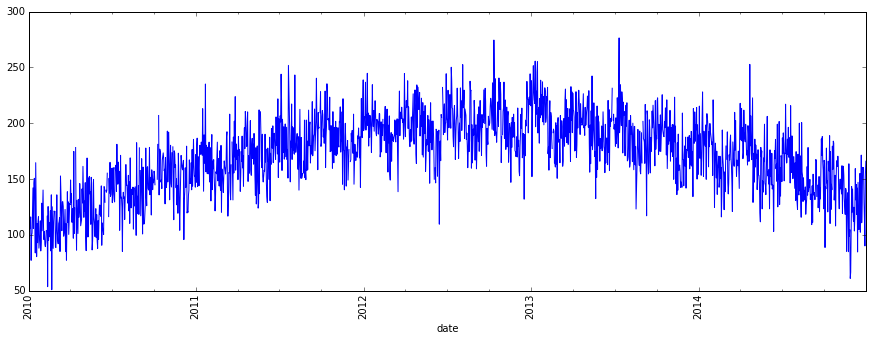

In [11]:
df['car.count'].plot(rot=90, figsize=(15,5));

I'd guess that we have a linear combination of a quadratic, sinusoid and random stochastic signal.


### Single Year Analysis: first year on record

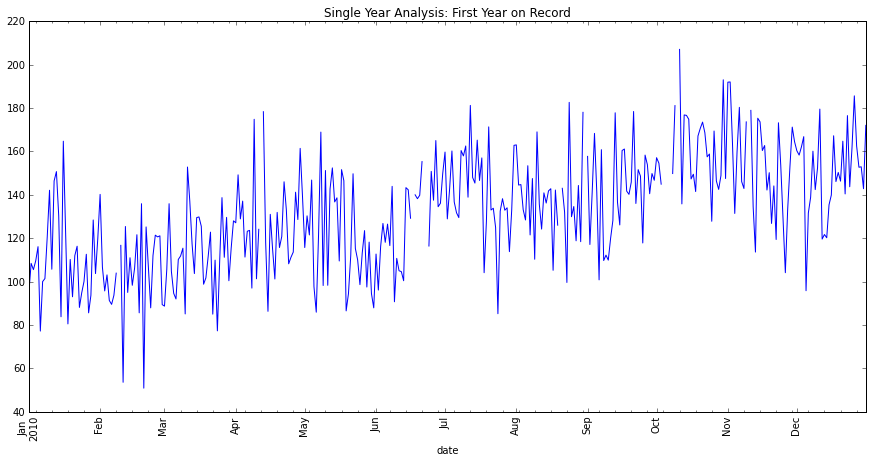

In [12]:
# year = df['car.count'][0:365]  if you are in a rush
year = df[df['date'] < pd.to_datetime('20110101')]['car.count']
year.plot(rot=90, figsize=(15,7), title="Single Year Analysis: First Year on Record");

In [13]:
#TODO: add to signal processing module

def remove_nans(data, return_nan_index=False):
    nan_ind = np.nonzero(~np.isfinite(data))[0]
    good_data_ind = np.nonzero(np.isfinite(data))[0]
    good_data = data[good_data_ind]
          
    new_points = np.interp(nan_ind, good_data_ind, good_data)
    data[nan_ind] = new_points
    
    if return_nan_index:
        return data, nan_ind
    else:
        return data

In [14]:
year, nan_ind = remove_nans(year.copy(), return_nan_index=True)
year_linear_det = signal.detrend(year, axis=0, type='linear')

<b>Single Year Linear Detrend Time Series</b>

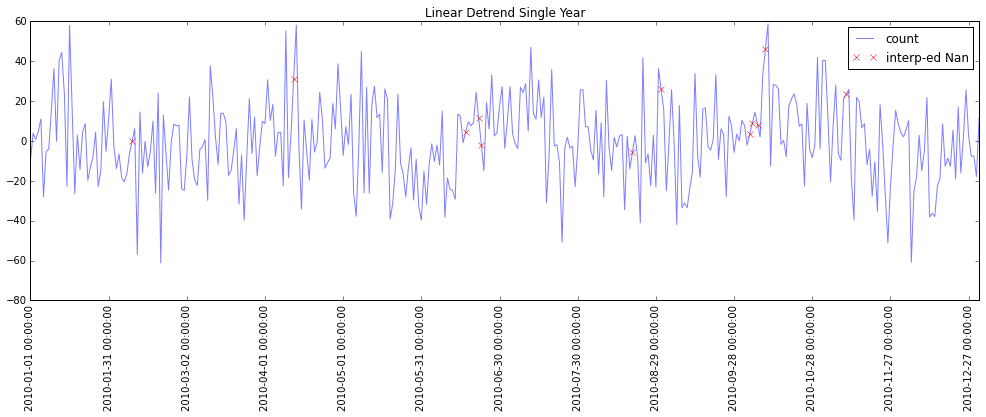

In [15]:
plt.figure(figsize=(17, 5))
plt.plot(year_linear_det, alpha=0.5)
plt.xticks(np.arange(year.shape[0])[0::30], year.index[0::30], rotation=90)
plt.plot(nan_ind, year_linear_det[nan_ind], 'rx')
plt.title("Linear Detrend Single Year")
plt.legend(('count', 'interp-ed Nan'))

Again we see $\approx$ 90 day period.

Without more insight about the data we don't know if this is a nuisance or
a feature we are looking for.

The NaN replacements look reasonable.

## 'Group By' for Sanity Check and Basic Analysis

<b>Group by Month: Global monthly trend averaging over the 5 samples of each month</b>

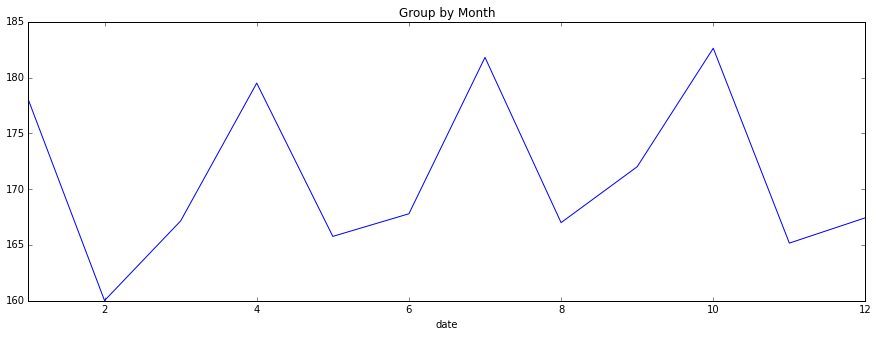

In [16]:
grp = df.groupby(df.date.map(lambda x:x.month))
grp.mean()['car.count'].plot(figsize=(15, 5), title="Group by Month");

A group-by is sort of like a Fourier Transform where we choose just one frequency bin. There's the sinusodial period $\approx$ 90 days.

<b>Group by Day: Global day trend averaging over the 5 samples of each day<b>

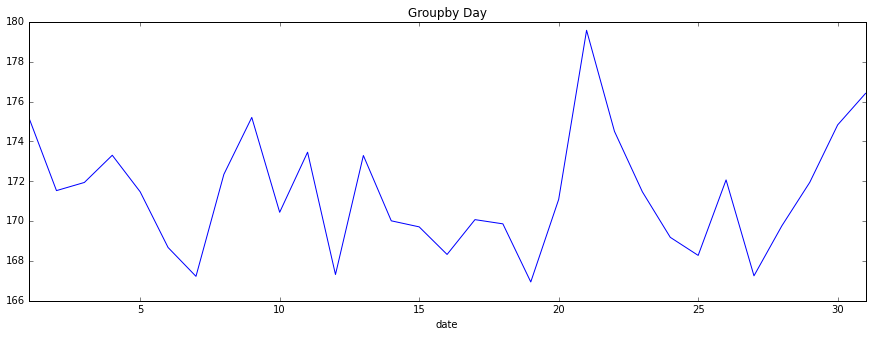

In [17]:
grp = df.groupby(df.date.map(lambda x:x.day))
grp.mean()['car.count'].plot(figsize=(15,5), title="Groupby Day");

It would appear as though the 21st day of each month saw greater count. 

## FFT
I keep this method handy, I didn't re-write just cut and paste rather than import so that you can see what's inside.

In [18]:
def fft(data):
        '''Plot FFT using Welch's method, daily resolution '''
        f, y = signal.welch(data, fs=1.0, nperseg=365, noverlap=None, nfft=512, scaling='spectrum', detrend="linear")
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        frqs = f[0::interval]
        plt.xticks(frqs, periods, rotation="vertical")
        
        plt.plot(f, y)
        
        plt.grid(True) # not working likely b/c of conflict with seaborn artist
        plt.title("Welch FFT: Counts")
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
               
        return f, y, frqs

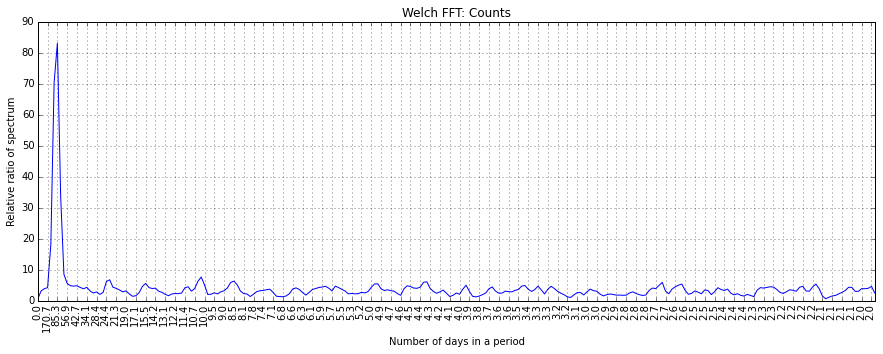

In [19]:
plt.figure(figsize=(15,5))
counts = remove_nans(df['car.count'].copy())
df['car.count.no-nans'] = counts
f, y, frqs = fft(counts)

## Quadratic Detrend Via PolyFit

In [20]:
poly =  np.polynomial.polynomial             

In [21]:
t = np.arange(df.shape[0])
coefs, stats = poly.polyfit(t, counts, deg=2, full=True)
fit_curve = poly.polyval(t, coefs)
df['quad_fit'] = fit_curve

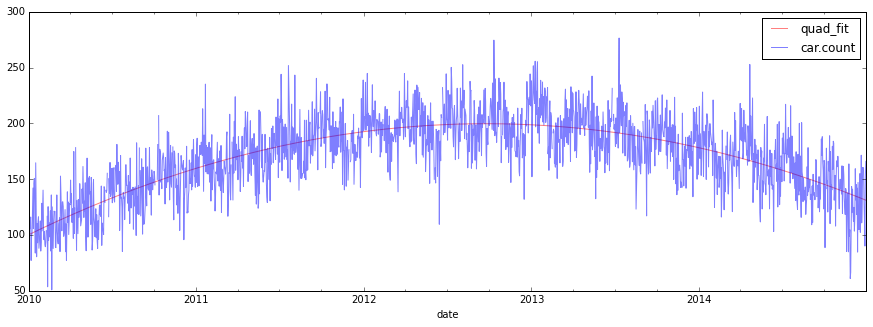

In [22]:
df[['quad_fit', 'car.count']].plot(figsize=(15, 5), alpha=0.5, color=['r', 'b'])

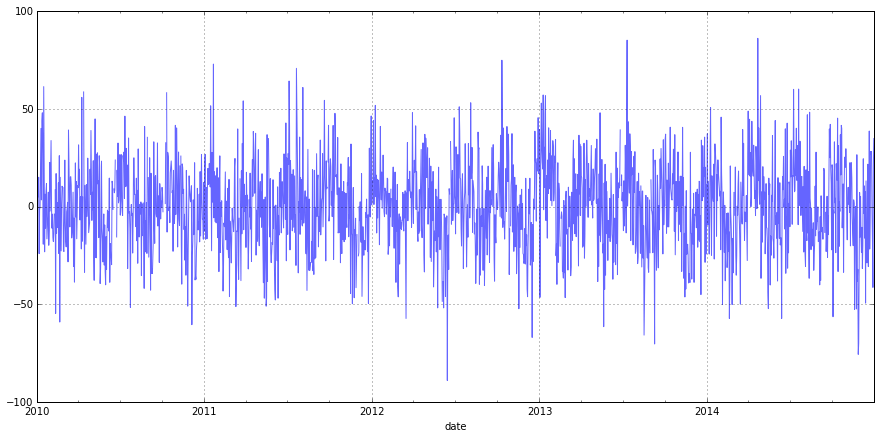

In [23]:
df['det_curve'] = df['car.count'] - df['quad_fit']
df['det_curve'].plot(figsize=(15, 7), alpha=0.6, grid=True)

## Further Confound Removal
Lets suppose that the quadratic is a measurement error and that the $\approx$ 90 day sinusodial is a well understood or nuisance, then we'll examine the remainder of the signal.

In [24]:
import sys
sys.path.append("/home/daniel/git/Python/MRI/Modules")
import SignalProcessTools

In [25]:
sigtools = SignalProcessTools.SignalProcessTools()

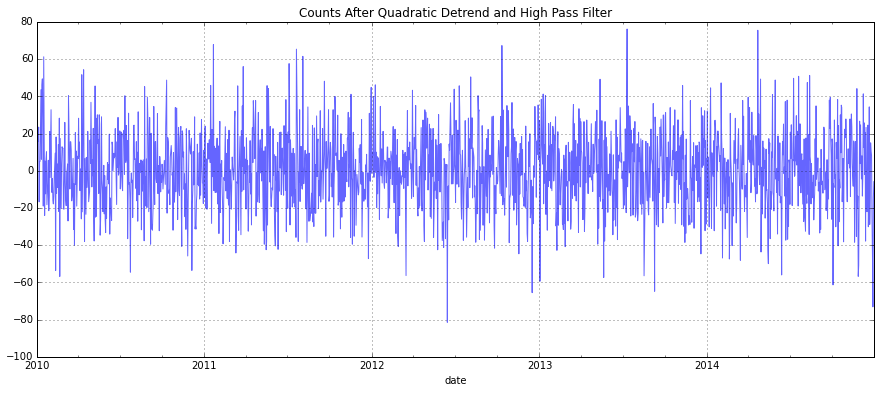

In [26]:
frq = 1.0 / 85.3 # from FFT output above
df['hi_pass'] = sigtools.hi_pass_filter(df['car.count.no-nans'], frq, 1.0, 2)
df['hi_pass'].plot(title="Counts After Quadratic Detrend and High Pass Filter", 
                   figsize=(15, 6), 
                   alpha=0.6, 
                   grid=True
                  )

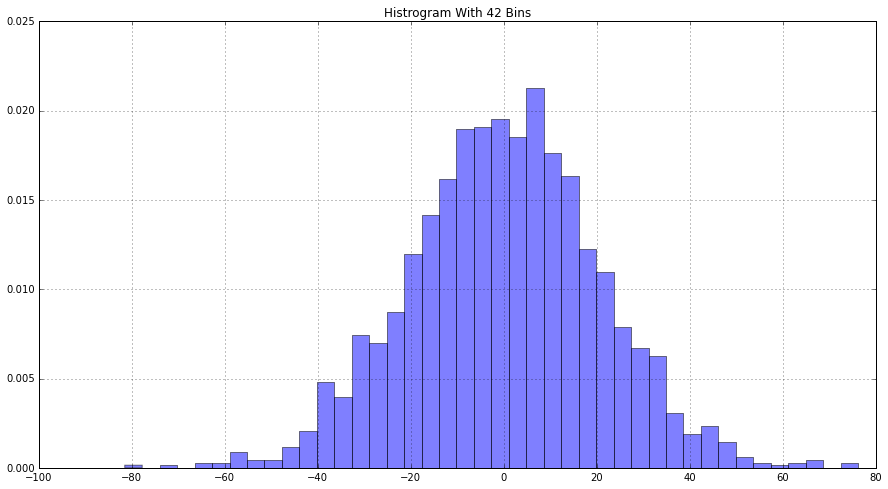

In [31]:
nbins = np.floor(np.sqrt(df.shape[0]))
plt.figure(figsize=(15,8))
y_counts, bin_x, patch = plt.hist(df['hi_pass'], nbins, normed=True, alpha=0.5);
string = "Histrogram With %s Bins" % str(int(nbins))
plt.title(string)
plt.grid()

In [51]:
bin_x = bin_x[1:]# drop the first bin to match the array lengths

In [52]:
from scipy.optimize import curve_fit

In [53]:
def gauss(x, *p):
    A, mu, sig = p
    gau = A * np.exp(-(x-mu)**2 / 2.0 * sig**2)
    return gau

In [54]:
coeff, var_matrix = curve_fit(gauss, bin_x, y_counts, p0=[0.1, 0.0, 0.1])
print coeff

[ 0.01997005  2.18612912  0.0504936 ]


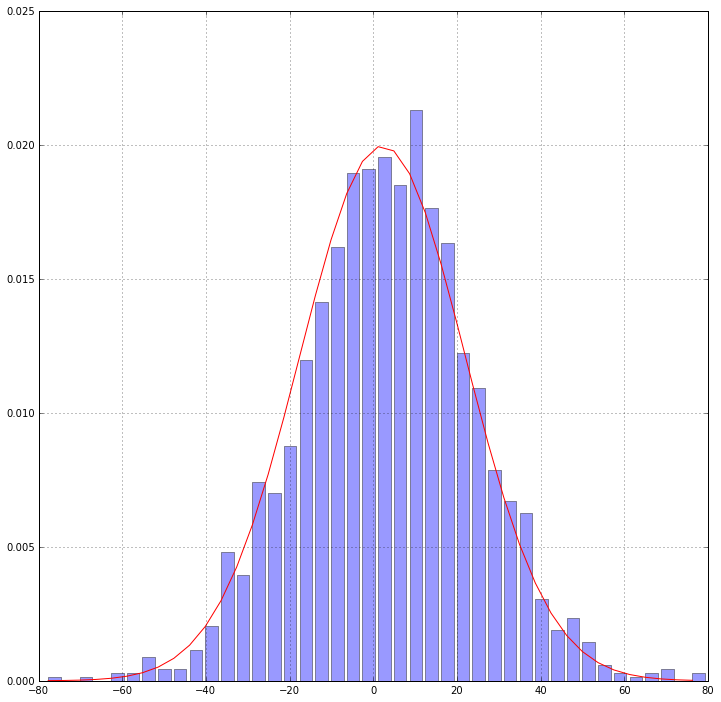

In [55]:
plt.figure(figsize=(12,12))
fit_gau = gauss(bin_x, *coeff)
plt.plot(bin_x, fit_gau, 'r')
plt.bar(bin_x, y_counts, alpha=0.4, width=3)
plt.grid()

#Boot Strap

It's great that we detrended and got down to a stochastic signal. 
Let's get a mean and some confidence that number is good.


In [76]:
mu = 0
# slow but transparent and simple to implement
for i in range(0, 1000):
    mu += df['car.count'].sample(n=100, replace=True).mean() # sample with replacement

print "bootstrapped mean:%f" % (mu / 1000.0)    
print "canoncial    mean:%f" % df['car.count'].mean()   

bootstrapped mean:171.264586
canoncial    mean:171.297387


# Analysis of NaN's

I'd like to see if there are any trends with respect to which data points are NaN's.

In [77]:
df['nans'] = df['car.count'].apply(lambda x: 1 if np.isnan(x) else 0)
df[df['nans'] == 1].head()

,date,day.of.week,car.count,weather,car.count.no-nans,quad_fit,det_curve,hi_pass,nans
date,,,,,,,,,
2010-02-09,2010-02-09,tuesday,NaN,0.4,110.300000,107.963584,NaN,3.069959,1
2010-04-12,2010-04-12,monday,NaN,0.8,151.200000,119.456371,NaN,27.423526,1
2010-06-17,2010-06-17,thursday,NaN,1.6,134.600000,130.846051,NaN,4.722415,1
2010-06-22,2010-06-22,tuesday,NaN,-0.5,142.333333,131.673415,NaN,9.068003,1
2010-06-23,2010-06-23,wednesday,NaN,-0.1,129.366667,131.838288,NaN,-4.542245,1


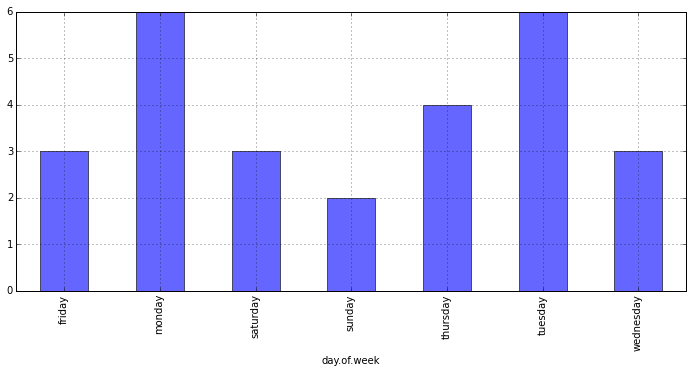

In [78]:
df[df['nans'] == 1].groupby('day.of.week').count()['date'].plot(kind='bar', figsize=(12, 5), alpha=0.6, grid=True)

Mondays and Tuesdays have the most missing data points. For traffic I imagine that's not a great day to
have concentrated failures. That could mean it's worth tracking down and fixing bugs or corner cases where the image processing fails to count.

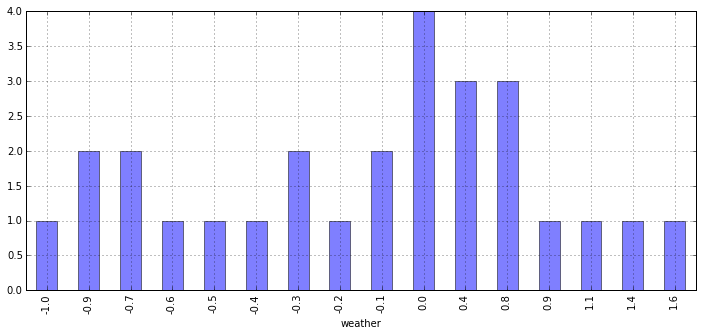

In [79]:
df[df['nans'] == 1].groupby('weather').count()['date'].plot(kind='bar', figsize=(12, 5), alpha=0.5, grid=True)

I'm curious is the weather effects the ability to count.

# Weather

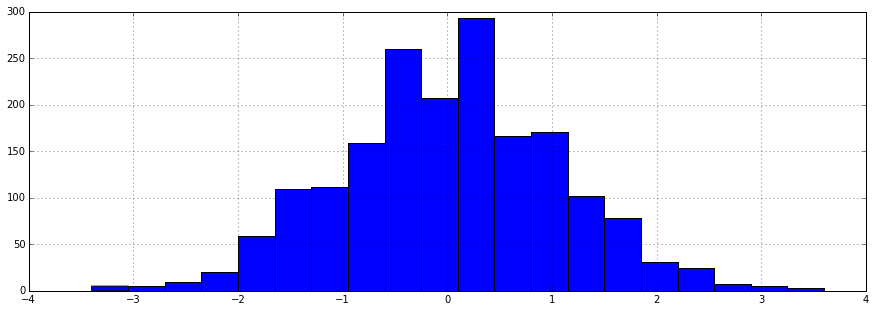

In [89]:
df['weather'].hist(bins=20, figsize=(15, 5))

## Correlation with Weather Signal

I'll start with a simple correlation with no controls for noise or random correlations.

Doesn't appear that the weather score and the car.count are correlated at all at $-0.021$.
In fact none of the fit curves correlation either.

In [30]:
df.corr()

,car.count,weather,car.count.no-nans,quad_fit,det_curve,hi_pass
car.count,1.000000,-0.019861,1.000000,0.763353,0.650295,0.612620
weather,-0.019861,1.000000,-0.021522,0.008422,-0.043456,-0.043225
car.count.no-nans,1.000000,-0.021522,1.000000,0.762886,0.650295,0.609761
quad_fit,0.763353,0.008422,0.762886,1.000000,0.005665,-0.012772
det_curve,0.650295,-0.043456,0.650295,0.005665,1.000000,0.958409
hi_pass,0.612620,-0.043225,0.609761,-0.012772,0.958409,1.000000


# Summary Write Up

Longer time scale:
If we were asked about global count increase, we could use the yearly and fit a quadratic to see that global 
trend.

Shorter time scale:
There's probably a strong correlation with some external related time series data that characterizes typical driving use cases.

Clearly there's an 85 day period with freqency $f = 1/T$ giving $f \approx$ 3 month recurring feature of high counts.